In [1]:
# ch3/ch3_4_dt/dt.ipynb
# 标准库
import sys

# 第三方库
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor

# 自定义模块
sys.path.append('./../../')
import utils.dataset as d
import utils.metrics as m
import utils.plot as p

# 绘图参数
name_model = 'DT'
name_var = 'PM2.5浓度'
name_unit = ' ($\mu g/m^3$)'
p.set_matplotlib(plot_dpi=80, save_dpi=600, font_size=12)


In [2]:
# 数据读取和统计分析
data = pd.read_csv('./../data/data_pm2_5.csv')
series = data['PM2_5'].values[:, np.newaxis]
ratio_train = 0.7  # 训练样本比例
num_train = int(len(series)*ratio_train)  # 训练样本数量

# 监督学习样本构建
H = 5
S = 1
train = d.series_to_supervised(series[0:num_train], H, S)  # [num_train, H+1]
test = d.series_to_supervised(series[num_train-H:], H, S)  # [num_test, H+1]
print(f"{train.shape=}, {test.shape=}")

# 训练测试样本划分
train_x = train.iloc[:, :-1].values  # [num_train, H]
train_y = train.iloc[:, -1].values[:, np.newaxis]  # [num_train, 1]
test_x = test.iloc[:, :-1].values  # [num_test, H]
test_y = test.iloc[:, -1].values[:, np.newaxis]  # [num_test, 1]
print(f'{train_x.shape=}, {train_y.shape=}')
print(f'{test_x.shape=}, {test_y.shape=}')

# 样本归一化
x_scalar = MinMaxScaler(feature_range=(0, 1))
y_scalar = MinMaxScaler(feature_range=(0, 1))
train_x_n = x_scalar.fit_transform(train_x)  # [num_train, H]
test_x_n = x_scalar.transform(test_x)  # [num_test, H]
train_y_n = y_scalar.fit_transform(train_y)  # [num_train, 1]
test_y_n = y_scalar.transform(test_y)  # [num_test, 1]
print(f'{train_x_n.shape=}, {train_y_n.shape=}')
print(f'{test_x_n.shape=}, {test_y_n.shape=}')


train.shape=(498, 6), test.shape=(217, 6)
train_x.shape=(498, 5), train_y.shape=(498, 1)
test_x.shape=(217, 5), test_y.shape=(217, 1)
train_x_n.shape=(498, 5), train_y_n.shape=(498, 1)
test_x_n.shape=(217, 5), test_y_n.shape=(217, 1)


In [3]:
# 决策树回归模型
model = DecisionTreeRegressor(
    criterion='mse',  # 衡量分支质量的指标
    splitter='best',  # 在各节点选择分支的策略
    max_depth=None,  # 树的最大深度
    min_samples_split=2,  # 划分内部节点需要的最小样本数量
    min_samples_leaf=1,  # 叶结点需要的最小样本数
)

# 训练
model.fit(train_x_n, train_y_n)

# 模型参数查看
print(f'{model.feature_importances_=}')  # 各特征对模型的重要性

# 测试
y_hat_n = model.predict(test_x_n)
y_hat_n = y_hat_n.reshape(-1, 1)
y_hat = y_scalar.inverse_transform(y_hat_n)  # [num_test, 1]

# 测试集-误差计算
print()
m.all_metrics(y_true=test_y, y_pred=y_hat)


model.feature_importances_=array([0.02028106, 0.01955499, 0.01438491, 0.02318442, 0.92259461])

mse=27.153
rmse=5.211
mae=3.864
mape=24.074%
sde=5.179
r2=0.731
pcc=0.885


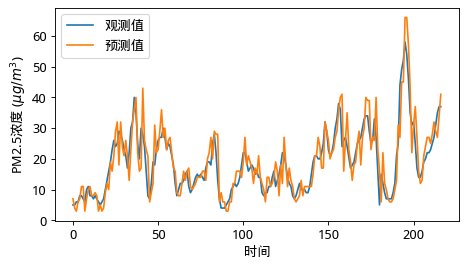

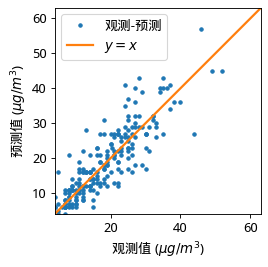

In [4]:
# 可视化
p.plot_results(
    y_true=test_y,
    y_pred=y_hat,
    xlabel='时间',
    ylabel=f'{name_var}{name_unit}',
    fig_name=f'{name_model}_预测曲线'
)
p.plot_parity(
    y_true=test_y,
    y_pred=y_hat,
    xlabel=f'观测值{name_unit}',
    ylabel=f'预测值{name_unit}',
    fig_name=f'{name_model}_Parity'
)
